## Simulation of between-subjects regressor effects on HDDM parameters

The goal of the script is to verify that effects of between-subjects regressor on 
HDDM parameters can be accurately estimated, including when there are also within-subject effects.

Values of a between-subject regressor on a or v are simulated by creating multiple subject datasets at increasing
values of the regressor.  

Created on Feb 8, 2017 by Michael

Oringinal `.py` file was from: https://groups.google.com/g/hddm-users/c/C96uz2_xFl8

In [1]:
import hddm
from numpy import mean, std
import numpy as np         
from pandas import Series
import pandas as pd
import os as os
import matplotlib.pyplot as plt

# os.chdir('/storage/home/mnh5174')


/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


### Generate data

In [2]:
beta_a = 0.4   # between subjects scaling factor - adjust this and should be able to recover its true value
a_int = 1      # set intercept within range of empirical priors 
v_int = 0.3
x_range = range(11)   # set values of between subject measures, here from 0 to 10
trials_per_level = 200    
subjs_per_bin = 10

data_group = pd.DataFrame()  # empty df to append to  

for x in x_range:
    xx = (x - mean(x_range)) / std(x_range)  # z-score the x factor
    a = a_int + beta_a * xx  #  indiv subj param values that are centered on intercept but deviate from it up or down by z-scored x
    # v = v_int+ beta_a*xx  # can also do for drift, here using same beta coeff
    
    # parvec = {'v':.3, 'a':a, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
    # parvec2 = {'v':.3, 'a':a+.5, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
    parvec = {'v':.3, 'a':a, 't':.3}  # set a to value set by regression, here v is set to constant

    # note that for subjs_per_bin > 1, these are just the mean values of the parameters; indiv subjs within bin are sampled from distributions with the given means, but can still differ within bin around those means. 
    #not including sv, sz, st in the statement ensures those are actually 0.

    data_a, params_a = hddm.generate.gen_rand_data({'level1': parvec}, size=trials_per_level, subjs=subjs_per_bin)
    
    # can also do with two levels of within-subj conditions
    # data_a, params_a = hddm.generate.gen_rand_data({'level1': parvec,'level2': parvec2}, size=trials_per_level, subjs=subjs_per_bin)

    data_a['z_x'] = Series(xx * np.ones((len(data_a))), index=data_a.index)  # store the (z-scored) between subjects factor in the data frame, same value for every row for each subject in the bin
    data_a['x'] = Series(x * np.ones((len(data_a))), index=data_a.index)  # store the (z-scored) between subjects factor in the data frame, same value for every row for each subject in the bin
    data_a['a_population'] = Series(a * np.ones((len(data_a))), index=data_a.index)  # store the (z-scored) between subjects factor in the data frame, same value for every row for each subject in the bin
    data_a['subj_idx'] = Series(x * subjs_per_bin + data_a['subj_idx'] * np.ones((len(data_a))), index=data_a.index)  # store the correct subj_idx when iterating over multiple subjs per bin
     
    # concatenate data_a with group data
    data_a_df = pd.DataFrame(data=[data_a])
    data_group = data_group.append([data_a], ignore_index=True)

#write original simulated data to file
data_group.to_csv('data_group.csv')

### Recover parameters

In [3]:
a_reg = {'model': 'a ~ 1 + z_x', 'link_func': lambda x: x}
# a_reg_within = {'model': 'a ~ 1+x + C(condition)', 'link_func': lambda x: x}
# for including and estimating within subject effects of  condition

v_reg = {'model': 'v ~ 1 + z_x', 'link_func': lambda x: x}
reg_comb = [a_reg, v_reg]
# m_reg = hddm.HDDMRegressor(data_group, reg_comb, group_only_regressors=['true']) 

# Do not estimate individual subject parameters for all regressors.
m_reg = hddm.HDDMRegressor(data_group, a_reg, group_only_regressors=['true'])
m_reg.find_starting_values()
m_reg.sample(3000, burn=500, dbname='a_bwsubs_t200.db', db='pickle')
m_reg.save('a_bwsubs_model_t200')

m_reg.print_stats()  # check values of reg coefficients against the generated ones

Adding these covariates:
['a_Intercept', 'a_z_x']


/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 3001 of 3000 complete in 4287.3 secWARNING: Will not save custom link functions.
                            mean       std      2.5q       25q       50q       75q     97.5q    mc err
v                       0.325144  0.017820  0.289625  0.313217  0.325032  0.337229  0.360310  0.000737
v_std                   0.109973  0.020171  0.070226  0.096745  0.109675  0.123076  0.152067  0.001418
v_subj.0.0              0.363587  0.110533  0.146917  0.292865  0.360106  0.432667  0.593871  0.002181
v_subj.1.0              0.324692  0.110679  0.095627  0.255560  0.327596  0.394070  0.551594  0.002278
v_subj.2.0              0.348583  0.110807  0.131570  0.276615  0.347867  0.421789  0.569165  0.002322
v_subj.3.0              0.299380  0.108130  0.079324  0.228556  0.300519  0.371850  0.507152  0.002209
v_subj.4.0              0.351559  0.111310  0.130279  0.277739  0.354731  0.424338  0.565312  0.002622
v_subj.5.0              0.326366  0.108863  0.100277 

### load from file and examine recovery

In [4]:
#load from file and examine recovery
m_reg = hddm.load('a_bwsubs_model_t200')
data_group = pd.read_csv('data_group.csv')

#look at correlation of recovered parameter with original
subjdf = data_group.groupby('subj_idx').first().reset_index()

## check for residual correlation with x 
a_int_recovered =[]

#obtain mean a intercept parameter for subjects
from scipy import stats
for i in range(0,(1+max(x_range))*subjs_per_bin):
    a='a_Intercept_subj.'
    a+=str(i)
    a+='.0'
    p1=m_reg.nodes_db.node[a] 
    a_int_recovered.append(p1.trace().mean())
    
#obtain mean a regression weight for z_x
a_x_recovered = m_reg.nodes_db.node['a_z_x'].trace().mean()

#compute predicted a parameter as a function of subject intercept and between-subjects regressor
subjdf.apred = a_int_recovered + a_x_recovered * subjdf.z_x


Pearson correlation between a_x and x
(0.9762506833861541, 1.429214596270688e-73)


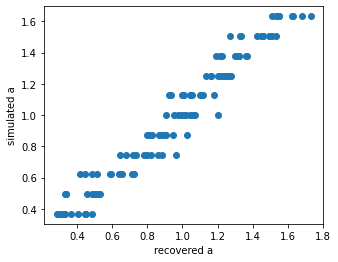

In [5]:
# correlation of recovered a with population a. r = .97 here: good!
fig = plt.figure()
fig.set_size_inches(5, 4)
plt.scatter(subjdf.apred,subjdf.a_population) # predicted versus observed a
plt.xlabel('recovered a')
plt.ylabel('simulated a')
plt.savefig('correlation of simulated and recovered a params.png', dpi=300, format='png')
print('Pearson correlation between a_x and x') 
print(stats.pearsonr(subjdf.apred,subjdf.a_population)) # correlation between predicted a value and population a value

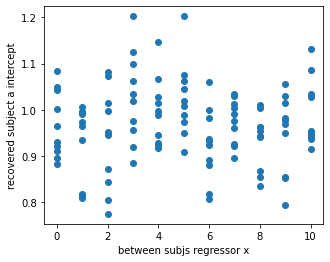

Pearson correlation between a_x and x
(0.002178625596488262, 0.9819784214850871)


<Figure size 432x288 with 0 Axes>

In [6]:
# correlation of subject intercept with between-subjects regressor
# should be zero correlation if entirely accounted for by x regressor - 
# this correlation should instead be positive if x is removed from the model fit
fig = plt.figure()
fig.set_size_inches(5, 4)
plt.scatter(subjdf.x,a_int_recovered)
plt.xlabel('between subjs regressor x')
plt.ylabel('recovered subject a intercept')
plt.show()
plt.savefig('residual correlation between subj intercept and x.png', dpi=300, format='png')
print('Pearson correlation between a_x and x') 
print(stats.pearsonr(a_int_recovered,subjdf.x))
